# Creating prior knowledge masks (Penumbra & Core)
Penumbra and Core are known at time of acute imaging and are essential components to the final infarct. Integrating these priors in a model could yield better results.

One Perfusion imaging:
- Penumbra is defined with Tmax > 6s
- Core is defined as rCBF < 30%

In [54]:
import sys, os
sys.path.insert(0, '../')
import numpy as np
from gsprep.visual_tools.visual import display, idisplay
from gsprep.tools.segmentation.ct_brain_extraction import ct_brain_extraction
from scipy.ndimage.filters import gaussian_filter
import scipy.ndimage.morphology as ndimage
from skimage.morphology import ball, disk

In [103]:
dataset_path = '/Users/julian/temp/perfusion_data_sets/isles_dataset/isles_data_set.npz'
n_subj = 94
has_mask = False
dilation_dimension = 2

In [104]:
raw_images = np.load(dataset_path, allow_pickle=True)['ct_inputs'][:n_subj].astype(np.float64)
raw_labels = np.squeeze(np.load(dataset_path, allow_pickle=True)['ct_lesion_GT'][:n_subj].astype(np.uint8))
# raw_labels = np.load(dataset_path, allow_pickle=True)['lesion_GT'][:n_subj].astype(np.float64)
if has_mask:
    raw_mask = np.load(dataset_path, allow_pickle=True)['brain_masks'][:n_subj]
params = np.load(dataset_path, allow_pickle=True)['params']

n_subj, n_x, n_y, n_z, n_c = raw_images.shape
raw_images.shape

(94, 256, 256, 22, 5)

Define helper functions



In [105]:
def dilation_structure_3d(radius):
    return ball(radius)

def dilation_structure_2d(radius):
    return np.expand_dims(disk(radius), axis=-1)

if dilation_dimension == 2:
    dilation_structure = dilation_structure_2d
elif dilation_dimension == 3:
    dilation_structure = dilation_structure_3d
else:
    raise NotImplementedError


In [106]:
def gaussian_smoothing(data, kernel_width=5, threeD=False):
    '''
    Smooth a set of n images with a 2D gaussian kernel on their x, y planes iterating through z
    if threeD is set to false; Every plane in z is smoothed independently
    Every channel is smoothed independently
    :param data: images to smooth (n, x, y, z, c)
    :param kernel_width: 2D or 3D kernel width
        Default width is 5 vxl - (stroke dataset: 10mm width), ie. 5mm radius as inspired by
        Campbell Bruce C.V., Christensen Søren, Levi Christopher R., Desmond Patricia M., Donnan Geoffrey A., Davis Stephen M., et al. Cerebral Blood Flow Is the Optimal CT Perfusion Parameter for Assessing Infarct Core. Stroke. 2011 Dec 1;42(12):3435–40.
    :param threeD, default False: exert smoothing in all 3 spatial dimensions and not only 2
    :return: smoothed_data
    '''
    if len(data.shape) != 5:
        raise ValueError('Shape of data to smooth should be (n, x, y, z, c) and not', data.shape)

    sigma = kernel_width / 3
    truncate = ((kernel_width - 1) / 2 - 0.5) / sigma
    smoothed_data = np.empty(data.shape)

    for i in range(data.shape[0]):
        for c in range(data.shape[4]):
            if not threeD:
                for z in range(data.shape[3]):
                    smoothed_data[i, :, :, z, c] = gaussian_filter(data[i, :, :, z, c], kernel_width / 3,
                                                                   truncate=truncate)
            else:
                smoothed_data[i, :, :, :, c] = gaussian_filter(data[i, :, :, :, c], kernel_width/3, truncate=truncate)

    return smoothed_data


def normalise_by_contralateral_median(data):
    '''
    Normalise an image by dividing every voxel by the median voxel value of the contralateral side
    :param data: image input data for all subjects in form of an np array [n_subj, x, y, z, c]
    :return: normalised array
    '''

    normalised_data = np.empty(data.shape)

    for subj in range(data.shape[0]):
        subj_data = data[subj]
        subj_normalised_data = subj_data.copy()
        x_center = subj_data.shape[0] // 2
        left_side_set_off = x_center
        if subj_data.shape[0] % 2 == 0:
            # if number voxels along x is even, split in the middle
            right_side_set_off = x_center
        else:
            # if number voxels along x is uneven leave out the middle voxel line
            right_side_set_off = x_center + 1

        # normalise left side
        right_side = subj_data[right_side_set_off:]
        right_side_median = np.median(right_side[np.nonzero(right_side)])
        subj_normalised_data[:left_side_set_off] = np.divide(subj_data[:left_side_set_off], right_side_median)

        # normalise right side
        left_side = subj_data[:left_side_set_off]
        left_side_median = np.median(left_side[np.nonzero(left_side)])
        subj_normalised_data[right_side_set_off:] = np.divide(subj_data[right_side_set_off:], left_side_median)

        if subj_data.shape[0] % 2 != 0:
            x_para_median_slices_mean = np.mean([
                                            np.mean(subj_data[x_center - 1][np.nonzero(subj_data[x_center - 1])]),
                                            np.mean(subj_data[x_center + 1][np.nonzero(subj_data[x_center + 1])])
                                        ])
            subj_normalised_data[x_center] = np.divide(subj_data[x_center], x_para_median_slices_mean)

        normalised_data[subj] = subj_normalised_data

    return normalised_data


## Create CSF mask

As false negative CSF masks can be harmful to the model, a safety margins is added and the csf mask is enlarged.

In [126]:
ncct_channel = 4
low_bounded_ncct = raw_images[..., ncct_channel][raw_images[..., ncct_channel] > 0]
up_and_low_bounded_ncct = low_bounded_ncct[low_bounded_ncct < 100]
# threshold = 20
threshold = np.percentile(up_and_low_bounded_ncct, 5)
csf_mask = gaussian_smoothing(raw_images[..., ncct_channel, None], kernel_width=3) < threshold
enlarged_csf_mask = np.array([ndimage.binary_dilation(csf_mask[idx, ..., 0], structure=dilation_structure(2)) for idx in range(csf_mask.shape[0])])
inv_csf_mask = -1 * enlarged_csf_mask + 1
inv_csf_mask.shape

(94, 256, 256, 22)

Image center:  127 127 10
Image center value:  11.0
Image center:  127 127 10
Image center value:  11.0


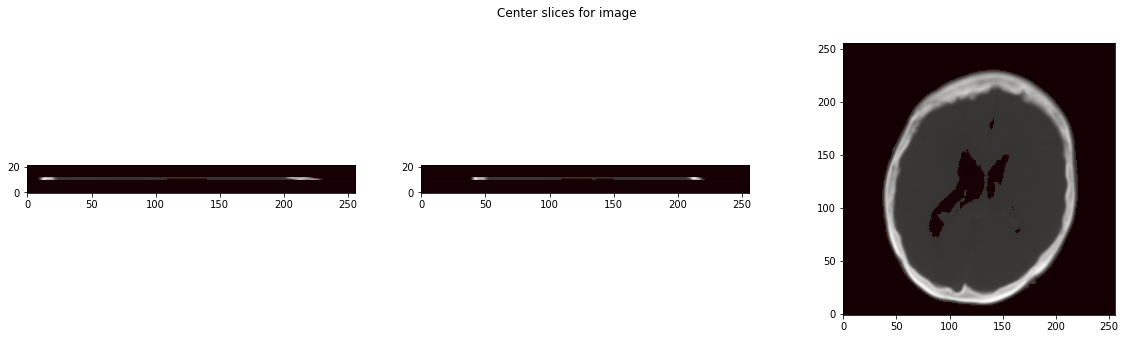

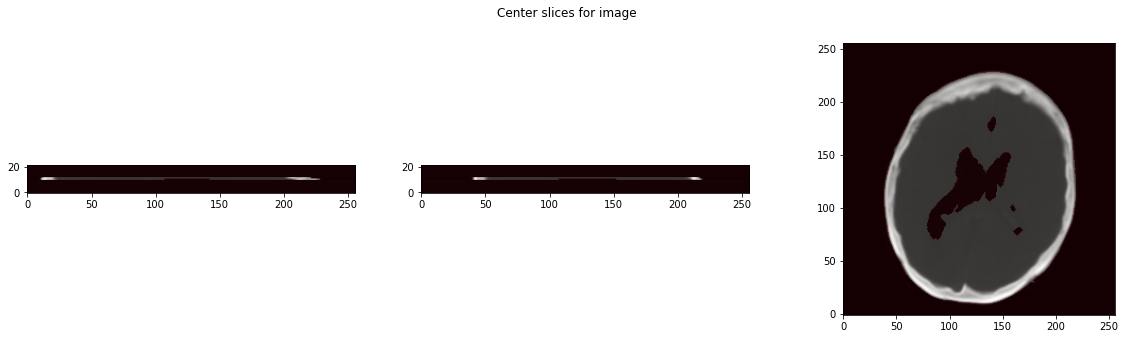

In [127]:
display(raw_images[0, ..., 4], mask=csf_mask[0])
display(raw_images[0, ..., 4], mask=enlarged_csf_mask[0])

## Create a skull mask


In [109]:
ncct_channel = 4
brain_mask = np.array([ct_brain_extraction(raw_images[subj, ..., ncct_channel], fsl_path='/usr/local/fsl/bin')[0]
                        for subj in range(n_subj)])
not_brain_mask = 1 - brain_mask
not_brain_mask.shape

200811-11:15:01,340 nipype.interface INFO:
	 stderr 2020-08-11T11:15:01.340752:/usr/local/fsl/bin/bet: line 151: /bin/remove_ext: No such file or directory
200811-11:15:01,342 nipype.interface INFO:
	 stderr 2020-08-11T11:15:01.342536:/usr/local/fsl/bin/bet: line 152: /bin/remove_ext: No such file or directory
200811-11:15:01,343 nipype.interface INFO:
	 stderr 2020-08-11T11:15:01.342536:/usr/local/fsl/bin/bet: line 154: /bin/imtest: No such file or directory
200811-11:15:01,343 nipype.interface INFO:
	 stderr 2020-08-11T11:15:01.342536:/usr/local/fsl/bin/bet: line 154: [: =: unary operator expected
200811-11:15:01,344 nipype.interface INFO:
	 stderr 2020-08-11T11:15:01.344933:/usr/local/fsl/bin/bet: line 236: /bin/bet2: No such file or directory
200811-11:15:16,0 nipype.interface INFO:
	 stderr 2020-08-11T11:15:16.000105:/usr/local/fsl/bin/bet: line 151: /bin/remove_ext: No such file or directory
200811-11:15:16,1 nipype.interface INFO:
	 stderr 2020-08-11T11:15:16.001816:/usr/local/f

(94, 256, 256, 22)

In [110]:
# enlargen slighlty
enlarged_not_brain_mask = np.array([ndimage.binary_dilation(not_brain_mask[subj], dilation_structure(3)) for subj in range(n_subj)])
inv_skull_mask = 1 - enlarged_not_brain_mask

### Alternative skull mask

If gsprep not available (pure python).

In [111]:
ncct_channel = 4
threshold = np.percentile(raw_images[..., ncct_channel], 90)
skull_mask = gaussian_smoothing(raw_images[..., ncct_channel, None], kernel_width=3) > threshold
enlarged_skull_mask = np.array([ndimage.binary_dilation(skull_mask[idx, ..., 0], structure=dilation_structure(1)) for idx in range(skull_mask.shape[0])])
alt_inv_skull_mask = -1 * enlarged_skull_mask + 1

Image center:  127 127 10
Image center value:  11.0
Image center:  127 127 10
Image center value:  11.0


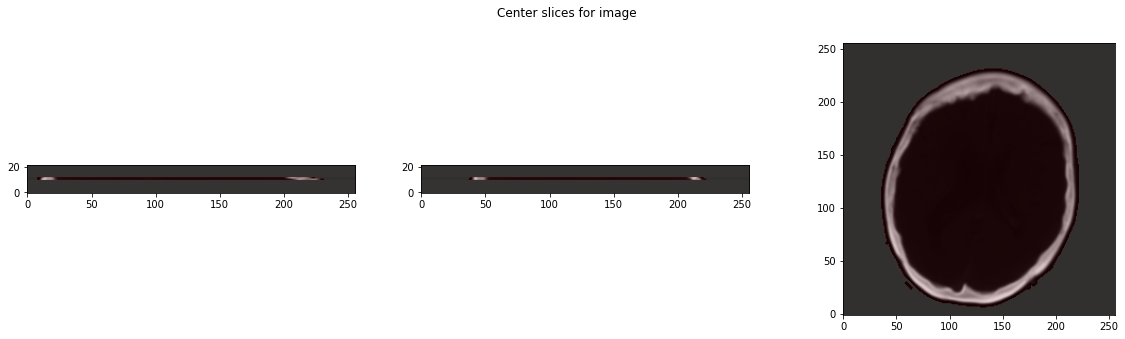

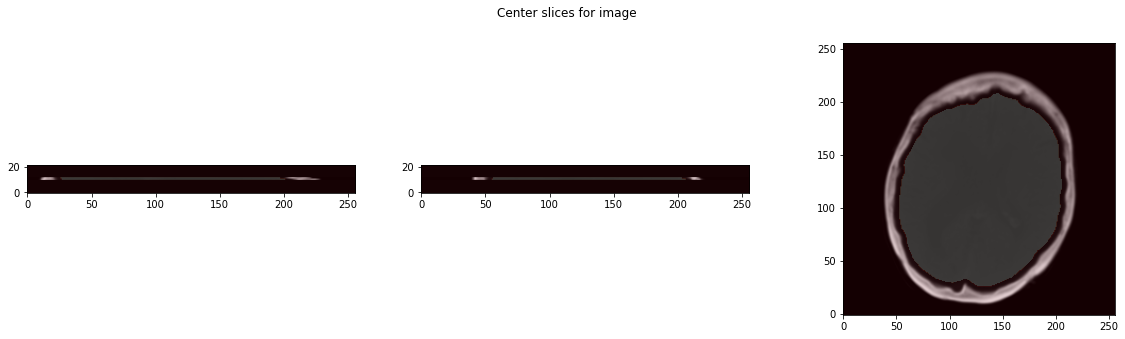

In [112]:
display(raw_images[0, ..., 4], mask=enlarged_skull_mask[0])
display(raw_images[0, ..., ncct_channel], mask=enlarged_not_brain_mask[0])


## Create major vessel mask

Major vessels create false positive signal on Tmax masks, but are easily recognisable on CBF

Better way to do this: Segment on VPCT?

In [113]:
cbf_channel = 1
threshold = np.percentile(raw_images[..., cbf_channel], 99)
vessel_mask = raw_images[..., cbf_channel] > threshold
enlarged_vessel_mask = np.array([ndimage.binary_dilation(vessel_mask[idx], structure=dilation_structure(2)) for idx in range(vessel_mask.shape[0])])
vessel_mask = enlarged_vessel_mask
inv_vessel_mask = -1 * vessel_mask + 1

Image center:  127 127 10
Image center value:  60.0
Image center:  127 127 10
Image center value:  False


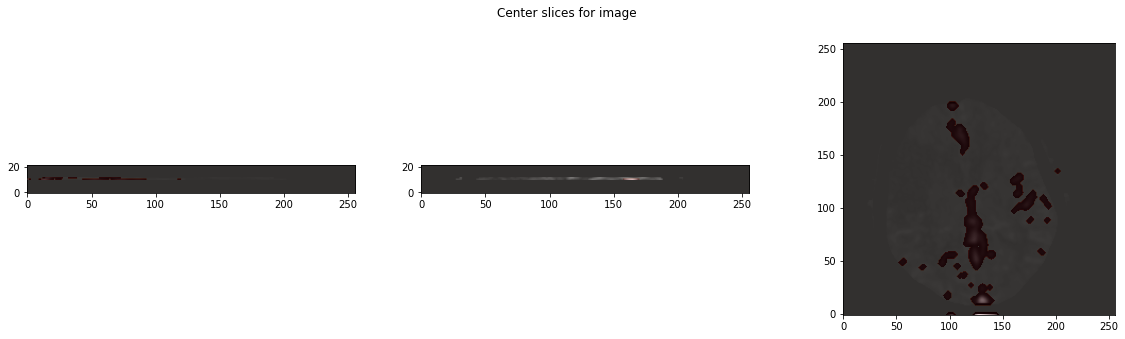

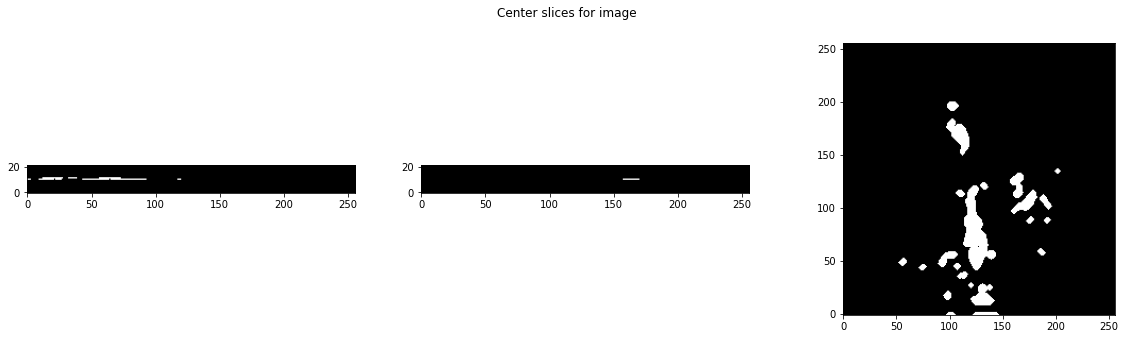

In [114]:
subj_idx = 1
display(raw_images[subj_idx,...,cbf_channel], mask=vessel_mask[subj_idx])
display(vessel_mask[subj_idx])

## Create Penumbra mask

In [115]:
raw_penumbra_masks = raw_images[..., 0] > 6
smooth_penumbra_masks = gaussian_smoothing(raw_images[..., 0, None], kernel_width=3) > 6
corr_csf_penumbra_masks = smooth_penumbra_masks * inv_csf_mask[..., None] # correct for CSF
corr_vx_penumbra_masks = corr_csf_penumbra_masks * inv_vessel_mask[..., None] # correct for CSF
# Todo correct for vessels

Image center:  127 127 10
Image center value:  True
Image center:  127 127 10
Image center value:  True
Image center:  127 127 10
Image center value:  0
Image center:  127 127 10
Image center value:  0
Image center:  127 127 10
Image center value:  8.0


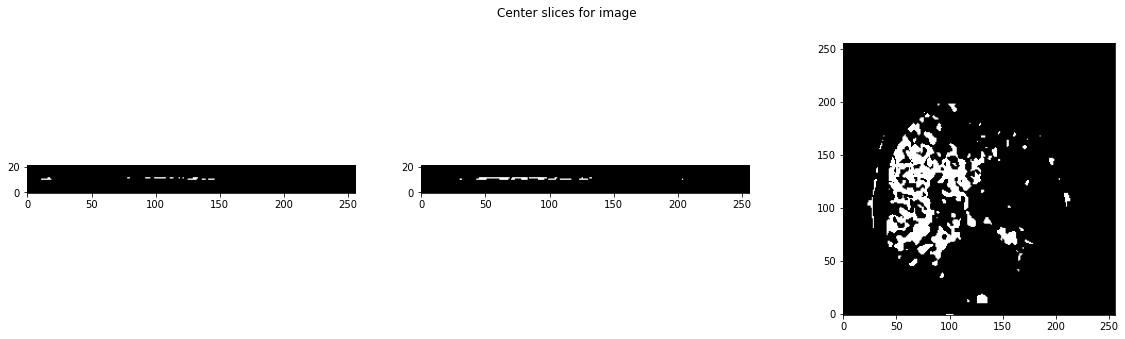

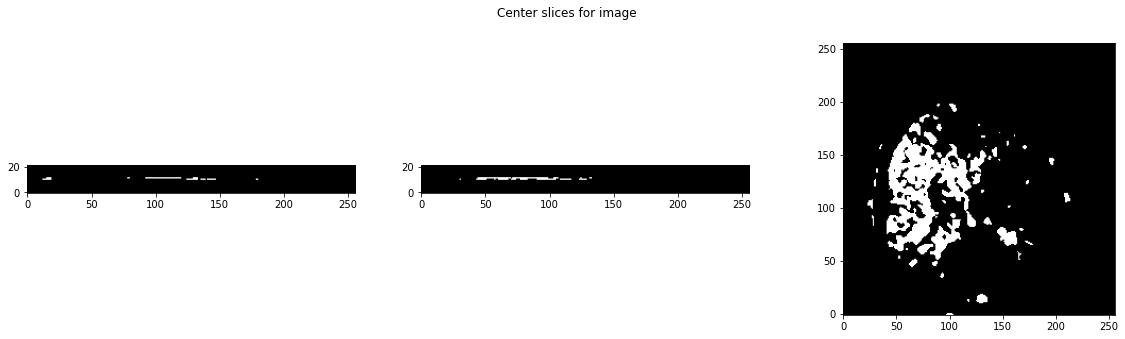

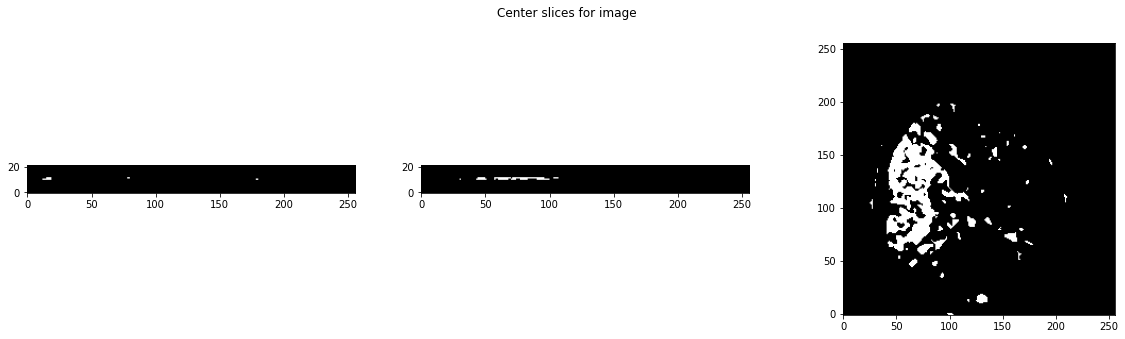

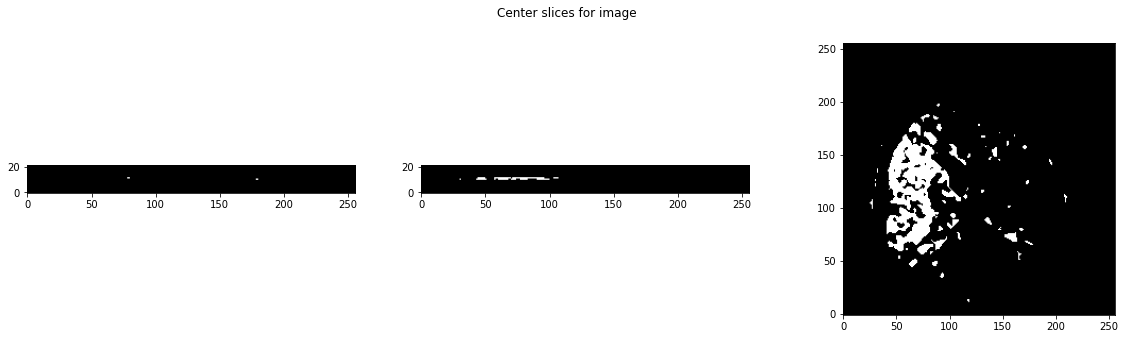

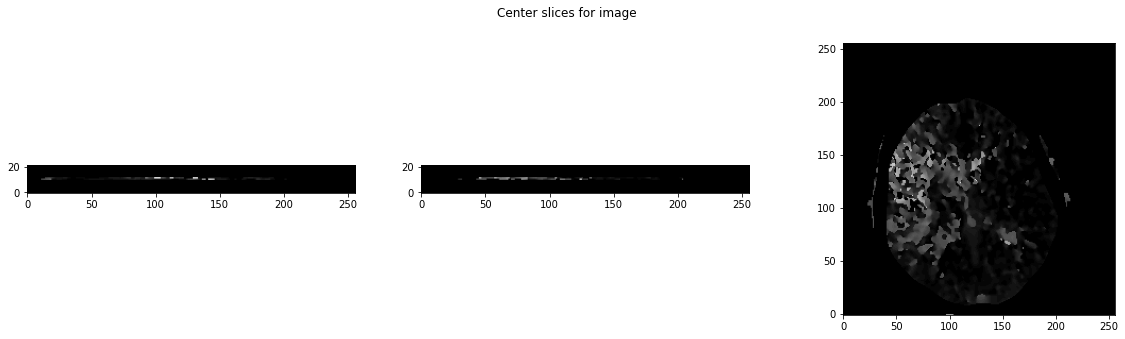

In [116]:
subj_idx = 1
display(raw_penumbra_masks[subj_idx])
display(smooth_penumbra_masks[subj_idx])
display(corr_csf_penumbra_masks[subj_idx, ..., 0])
display(corr_vx_penumbra_masks[subj_idx, ..., 0])
display(raw_images[subj_idx, ..., 0])


## Create Core mask



In [128]:
rCBF = normalise_by_contralateral_median(raw_images[..., 1])
smooth_rCBF = normalise_by_contralateral_median(gaussian_smoothing(raw_images[..., 1, None], kernel_width=2))
raw_core_masks = rCBF < 0.38
smooth_core_masks = smooth_rCBF < 0.38
corr_csf_core_masks = smooth_core_masks * inv_csf_mask[..., None]
corr_vx_core_masks = corr_csf_core_masks * inv_vessel_mask[..., None]
corr_skull_core_masks = corr_vx_core_masks * inv_skull_mask[..., None]

Image center:  127 127 10
Image center value:  60.0
Image center:  127 127 10
Image center value:  False
Image center:  127 127 10
Image center value:  False
Image center:  127 127 10
Image center value:  0
Image center:  127 127 10
Image center value:  0
Image center:  127 127 10
Image center value:  0
Image center:  127 127 10
Image center value:  8.0


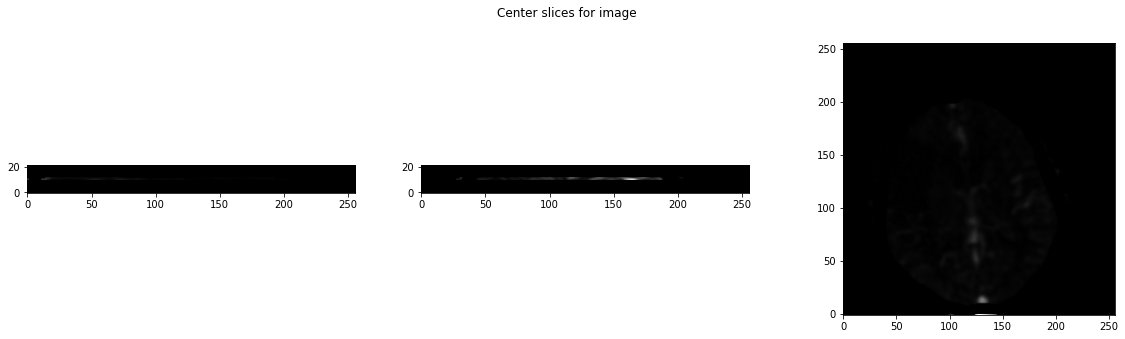

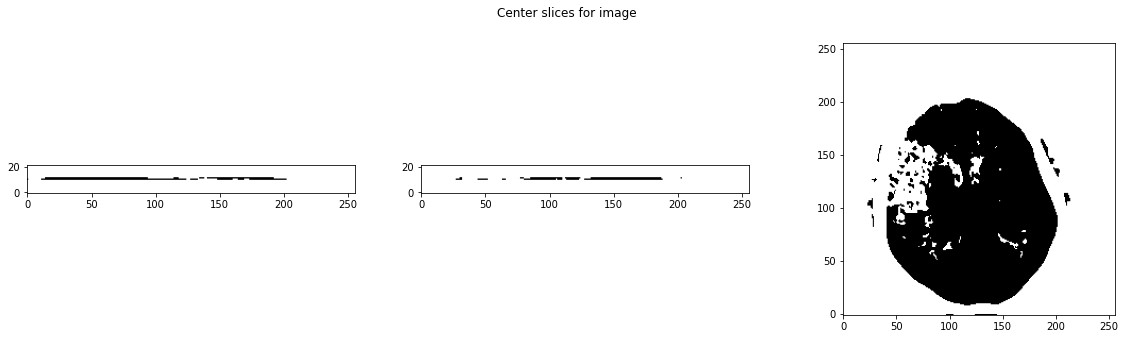

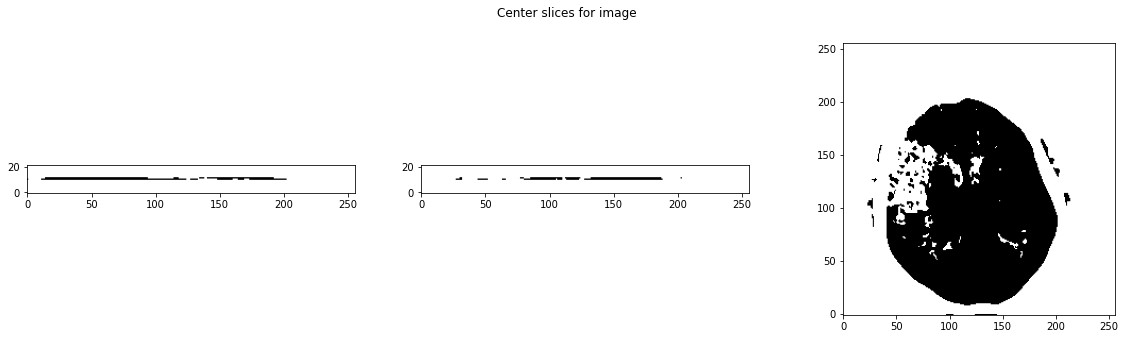

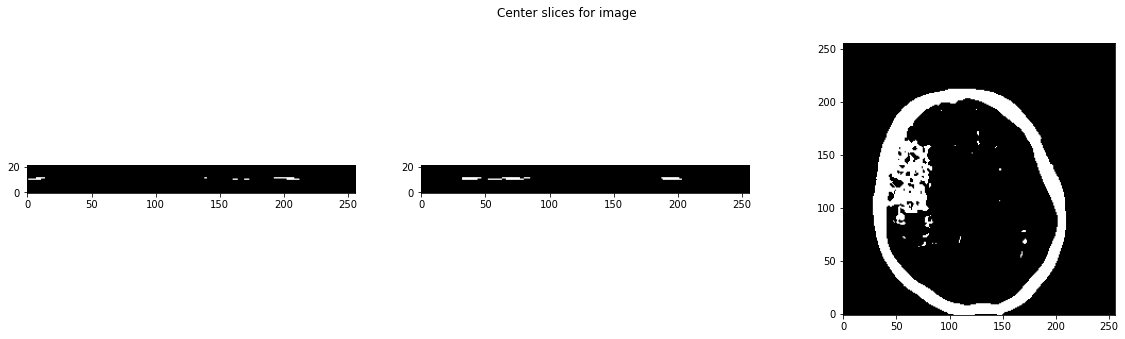

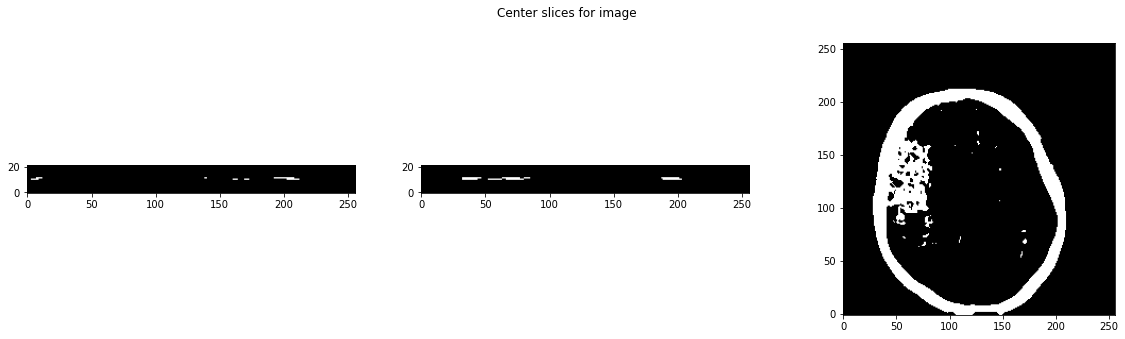

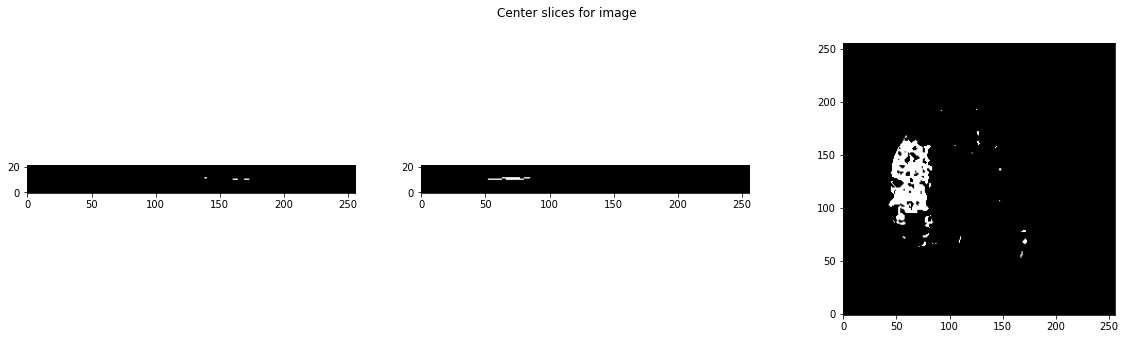

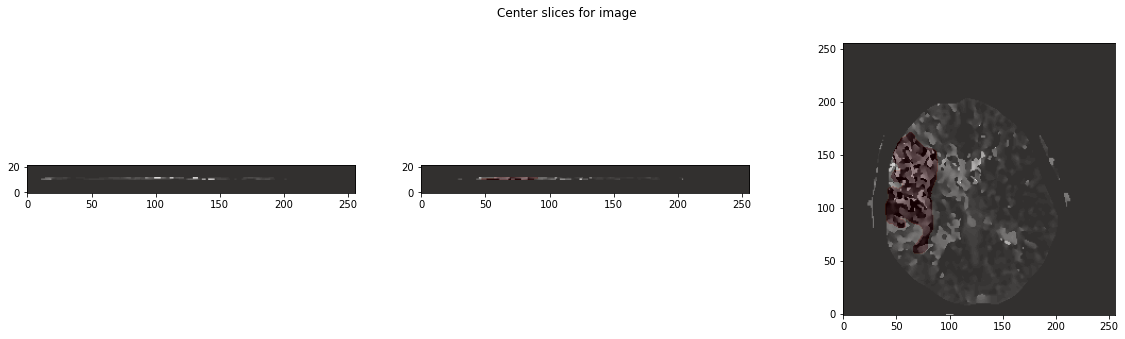

In [129]:
subj_idx = 1
display(raw_images[subj_idx, ..., 1])
display(raw_core_masks[subj_idx])
display(smooth_core_masks[subj_idx])
display(corr_csf_core_masks[subj_idx])
display(corr_vx_core_masks[subj_idx])
display(corr_skull_core_masks[subj_idx])
display(raw_images[subj_idx, ...,0], mask=raw_labels[subj_idx])

Restrict to defined brain mask


In [130]:
if has_mask:
    restr_core = corr_skull_core_masks * raw_mask[..., None]
    restr_penumbra = corr_vx_penumbra_masks * raw_mask[..., None]
else:
    restr_core = corr_skull_core_masks
    restr_penumbra = corr_vx_penumbra_masks

Image center:  127 127 10
Image center value:  8.0
Image center:  127 127 10
Image center value:  8.0
Image center:  127 127 10
Image center value:  0


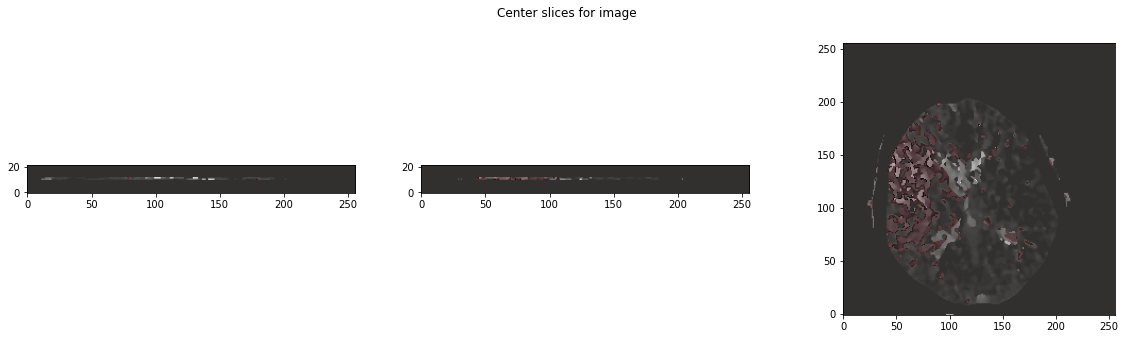

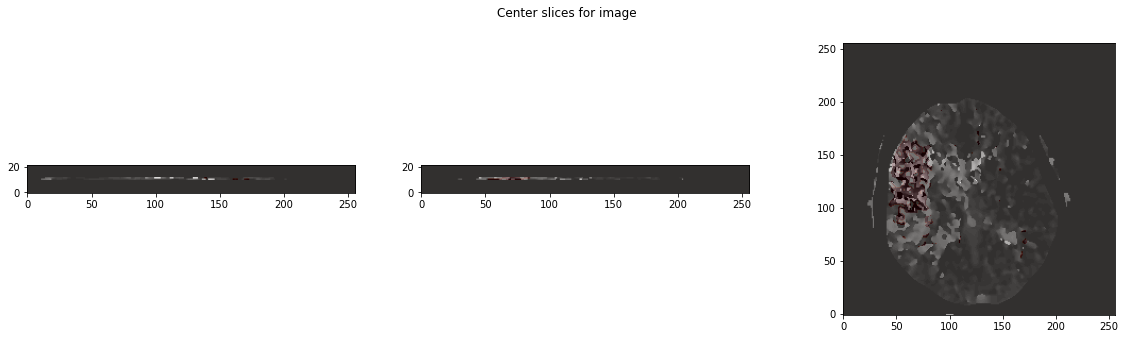

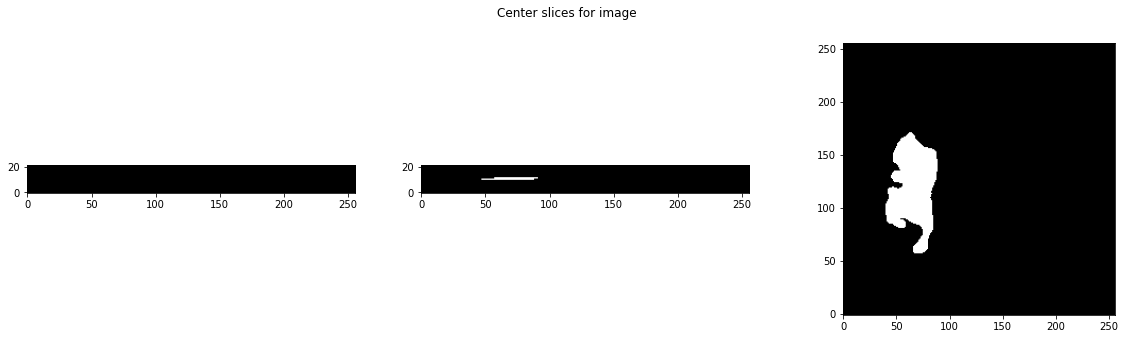

In [131]:
subj_idx = 1
display(raw_images[subj_idx, ...,0], mask=restr_penumbra[subj_idx])
display(raw_images[subj_idx, ...,0], mask=restr_core[subj_idx])
display(raw_labels[subj_idx])


Stats


In [132]:
# GT in penumbra
np.sum(restr_penumbra[..., 0] * raw_labels) / np.sum(raw_labels)


0.6761727785493471

In [133]:
# Core in GT
overall_core_in_gt = np.sum(restr_core[..., 0] * raw_labels) / np.sum(restr_core)
overall_core_in_gt


0.4352956248798924

/Users/julian/opt/anaconda3/envs/pnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(nan, nan, nan)

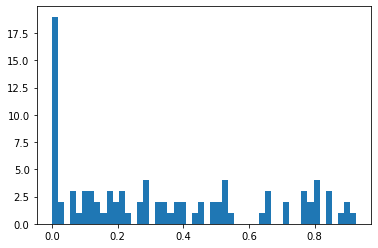

In [134]:
import matplotlib.pyplot as plt
core_in_gt = np.sum(restr_core[..., 0] * raw_labels, axis=(1,2,3)) / np.sum(restr_core[..., 0], axis=(1,2,3))
plt.hist(core_in_gt, bins=50)
np.median(core_in_gt), np.mean(core_in_gt), np.std(core_in_gt)

In [135]:
core_not_in_label = restr_core.copy()
core_not_in_label[raw_labels == 1] = 0


Image center:  127 127 10
Image center value:  8.0
Image center:  127 127 10
Image center value:  8.0


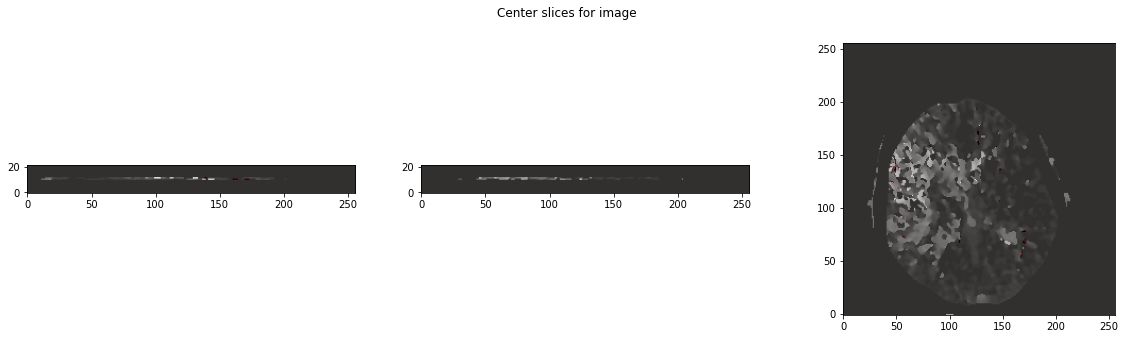

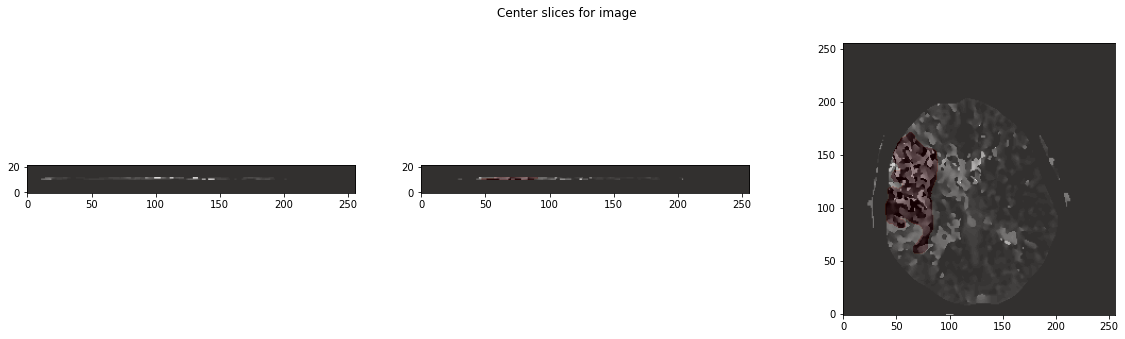

0.9262254901960785

In [136]:
subj_idx = 1
display(raw_images[subj_idx, ...,0], mask=core_not_in_label[subj_idx])
display(raw_images[subj_idx, ...,0], mask=raw_labels[subj_idx])
core_in_gt[subj_idx]

In [137]:
ids = np.load(dataset_path, allow_pickle=True)['ids']

In [138]:
ids[subj_idx]

'case_69'